# Overview
## Scenario
Pricing optimization is, non surprisingly, another area where data science can provide huge
value. The goal here is to evaluate whether a pricing test running on the site has been successful.
As always, you should focus on user segmentation and provide insights about segments
who behave differently as well as any other insights you might find.

## Recommendation
I would advise adoption of the $59 price increase which should lead to a 18% increase in revenue per visitor. Further, I would advise strategic consideration of the following interventions:
1. Incentivising user referrals
2. Reducing sample size in future A/B tests to be roughly 1,000 to 10,000
3. Deprecating the Linux version of the software

## Questions
1. Should the company sell its software for \$39 or \$59?
2. What are your main findings looking at the data?
3. The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

## Answers
1. Increasing the price of the software from \$39 to \$59 should yield an **increase in revenue of 18%**. Given this, **I advise raising the price**.
2. Some observations regarding the data
    1. Conversion rate varies by OS with: **iOS/mac > windows/android > linux**
    2. Conversion rate varies by source, and **friend referrals double conversion rate**
    3. Conversion rate decreased under all os, device, and source conditions, although we do not have sufficient statistical power to conclude that at alpha = 0.05 in some cases
    4. I would suggest a ratio of 1:1 experimental:control in the future to reduce the amount of time the experiment takes to run
3. An experiment of around 1,000 samples should be sufficient if we don't care about segmenting our users. I would not advise experiments as large as this one in the future.

## Contents
1. Data import and cleaning
2. Exploratory data analysis
3. Evaluating the business impact of a price intervention
4. Further insights
    1. Segmentation of users
    2. Geographic segmentation
5. Sample size estimation
6. Conclusion

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

mpl.rcParams['figure.dpi']= 120

# Data import and cleaning
There are two tables here: the experimental results and further user data. The user data is highly incomplete.

In [3]:
dtype = {
    'user_id' :'int',
    'city'    :'category',
    'country' :'category',
    'lat'     :'float',
    'long'    :'float'
}

df_users = pd.read_csv('user_table.csv', dtype=dtype)
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null category
country    275616 non-null category
lat        275616 non-null float64
long       275616 non-null float64
dtypes: category(2), float64(2), int64(1)
memory usage: 7.1 MB


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
dtype = {
    'user_id'          :'int',
    'timestamp'        :'str',
    'source'           :'category',
    'device'           :'category',
    'operative_system' :'category',
    'test'             :'bool',
    'price'            :'int',
    'converted'        :'bool'
}

df_results_table = pd.read_csv('test_results.csv', dtype=dtype)
df_results_table['timestamp'] = pd.to_datetime(df_results_table['timestamp'], errors='coerce')

df_results_table.info()
df_results_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           306529 non-null datetime64[ns]
source              316800 non-null category
device              316800 non-null category
operative_system    316800 non-null category
test                316800 non-null bool
price               316800 non-null int64
converted           316800 non-null bool
dtypes: bool(2), category(3), datetime64[ns](1), int64(2)
memory usage: 8.8 MB


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,False,39,False
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,False,39,False
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,False,39,False
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,True,59,False
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,False,39,False


In [5]:
df_results = df_results_table.join(df_users, on='user_id', rsuffix='_join')
df_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,user_id_join,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,False,39,False,NaN,NaN,NaN,NaN,NaN
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,False,39,False,NaN,NaN,NaN,NaN,NaN
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,False,39,False,NaN,NaN,NaN,NaN,NaN
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,True,59,False,NaN,NaN,NaN,NaN,NaN
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,False,39,False,NaN,NaN,NaN,NaN,NaN


# Exploratory data analysis
There is a large class imbalance in the data because most customers do not convert. Further, the conditions are imballanced since fewer total people saw the $59 price.

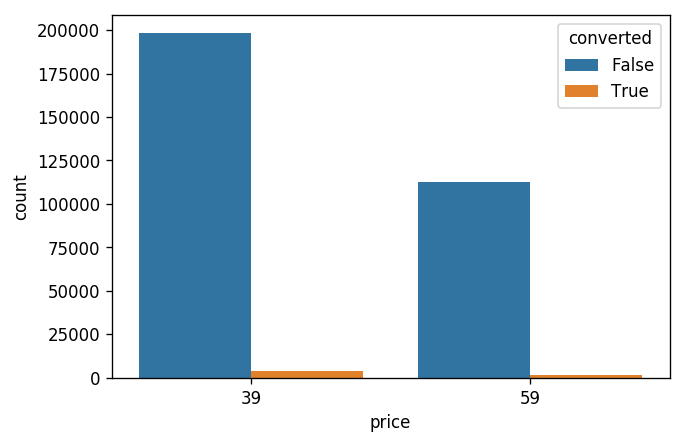

In [6]:
sns.countplot(data=df_results, x='price', hue='converted')

We see a consistent, small decrease in the increased-price group over the duration of the experiment. The moving average doesn't change very much over the course of the experiment, suggesting it has been run long enough.

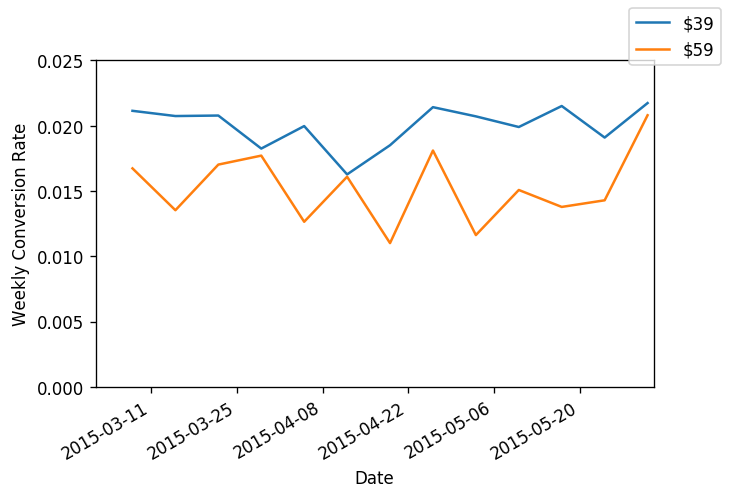

In [22]:
# Initialization
labels = []
fig, ax = plt.subplots()

# Plot weekly conversion rate vs time for each condition
for price, df in df_results.groupby("price"):
    df = df.dropna()
    df = df.set_index(df['timestamp'])
    df = df.sort_index()
    df_mean = df[['converted']].resample('1w').mean()
    df_mean['timestamp'] = df_mean.index
    sns.lineplot(data=df_mean, x='timestamp', y='converted')
    labels.append('$'+str(price))
    
# Make plot look nice
plt.xlim([np.min(df_results.timestamp), np.max(df_results.timestamp)])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Weekly Conversion Rate')
plt.ylim([0,0.025])
fig.legend(labels=labels)

Now that we have convinced ourselves that the experiment did not change much over time, we should interpret the results of the experiment. We will adopt an alpha of 0.05 to give a good tradeoff of experimental power and false positive rate. The 95% CI bars are clearly not overlapping, and the sample size is large enough to use an unpaired t-test to asses signifigance. The assumption of equal variance holds because the 95% CI is similar across conditions. The assumption of normality holds because of the large sample size and the central limit theorem.

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Conversion Rate')

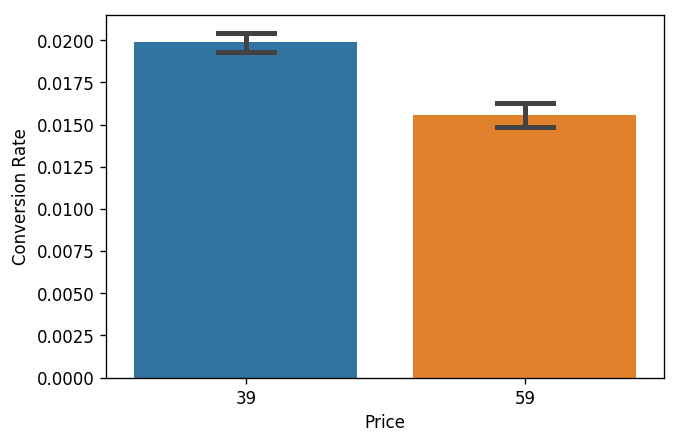

In [8]:
sns.barplot(data=df_results, x='price', y='converted', errwidth=3, capsize=0.2, n_boot=1000, ci=95)

plt.xlabel('Price')
plt.ylabel('Conversion Rate')

In [9]:
original_price = df_results[df_results['price']==39]['converted']
increased_price = df_results[df_results['price']==59]['converted']

p = stats.ttest_ind(original_price, increased_price)
print('There is a signifigant difference in conversion rate, p = ' + str(p[1]))

There is a signifigant difference in conversion rate, p = 3.3246559528871676e-18


# Assessing the business impact
To assess business impact, we look at the revenue per customer (average price\*converted) for each condition. We find that revenue per visitor increases significantly.

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Revenue per visitor ($)')

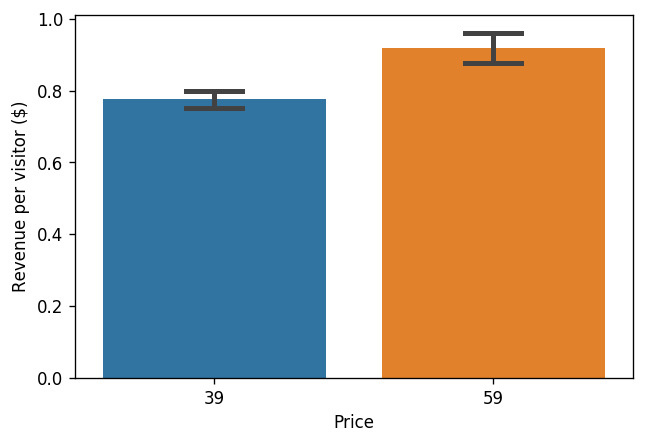

In [10]:
df_results['revenue'] = df_results['converted'].values.astype(int) * df_results['price'].values.astype(int)
sns.barplot(data=df_results, x='price', y='revenue', errwidth=3, capsize=0.2, n_boot=1000, ci=95)

plt.xlabel('Price')
plt.ylabel('Revenue per visitor ($)')

In [11]:
original_price = df_results[df_results['price']==39]['revenue']
increased_price = df_results[df_results['price']==59]['revenue']

p = stats.ttest_ind(original_price, increased_price)
print('There is a signifigant difference in revenue, p = ' + str(p[1]))

There is a signifigant difference in revenue, p = 4.085418202016159e-10


In [12]:
pct_change_in_revenue = round((np.mean(increased_price) - np.mean(original_price)) / np.mean(original_price) * 100)
print('Revenue is expected to increase by ' + str(pct_change_in_revenue) + '% after intervention.')

Revenue is expected to increase by 18% after intervention.


/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Increase in revenue per customer ($)')

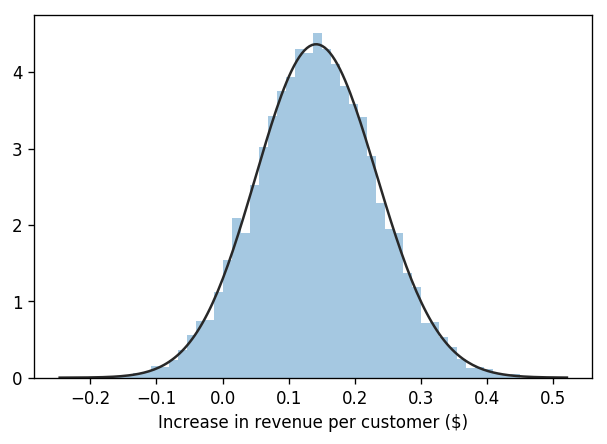

In [41]:
iters = 10000
difference = np.zeros(iters)
for i in range(iters):
    mean_original = np.mean(np.random.choice(original_price, len(original_price), replace = True))
    mean_increased = np.mean(np.random.choice(increased_price, len(increased_price), replace = True))
    difference[i] = mean_increased - mean_original
    
sns.distplot(difference, kde=False, fit=stats.gamma);
plt.xlabel('Increase in revenue per customer ($)')

# Further insights
## Segmentation of users
Comparing other features in the dataset shows a few more trends:
1. Conversion rate varies by OS with: iOS/mac > windows/android > linux
2. Conversion rate varies by source, with friend referrals doubling conversion rate
3. Conversion rate decreased under all os, device, and source conditions, although we do not have sufficient statistical power to conclude that at alpha = 0.05 in some cases

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


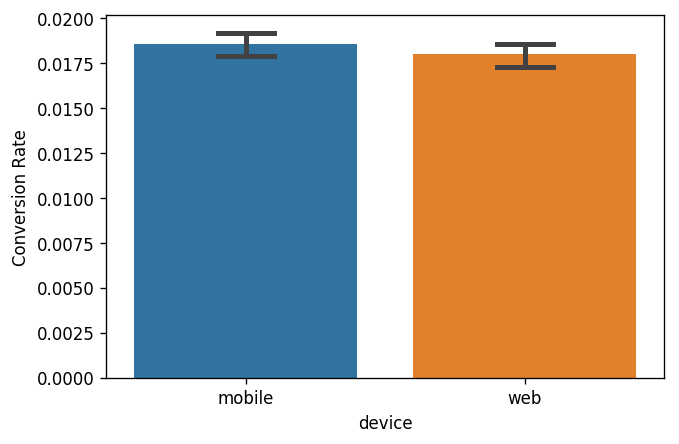

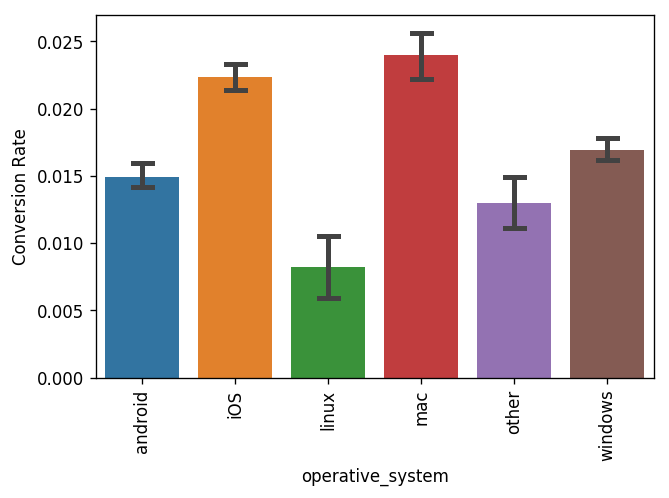

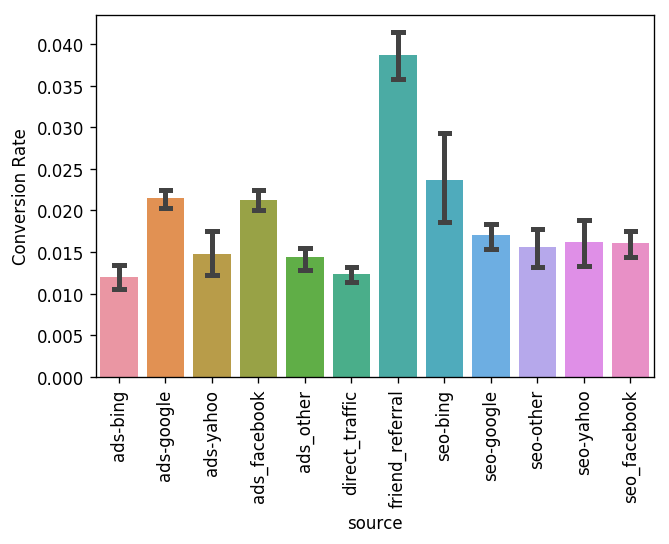

In [13]:
sns.barplot(data=df_results, x='device', y='converted', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.ylabel('Conversion Rate')
plt.show()

sns.barplot(data=df_results, x='operative_system', y='converted', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.xticks(rotation=90)
plt.ylabel('Conversion Rate')
plt.show()

sns.barplot(data=df_results, x='source', y='converted', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.xticks(rotation=90)
plt.ylabel('Conversion Rate')
plt.show()

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


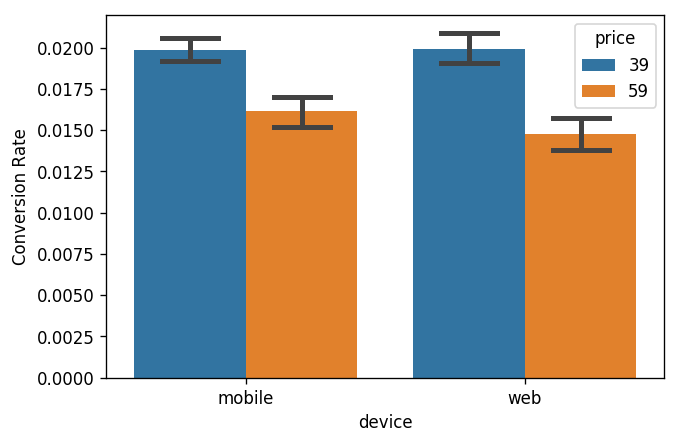

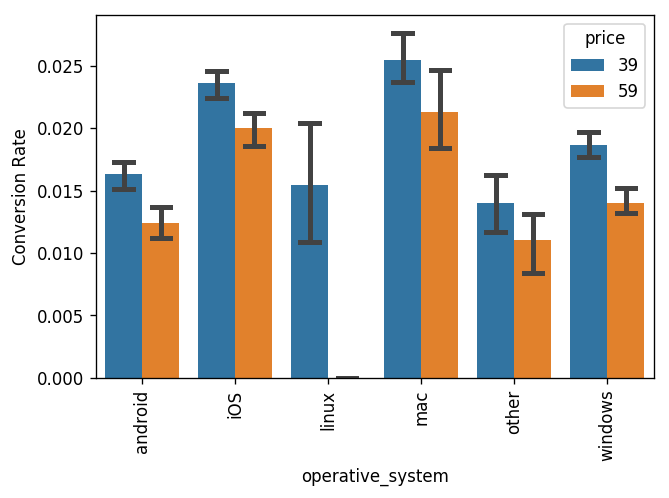

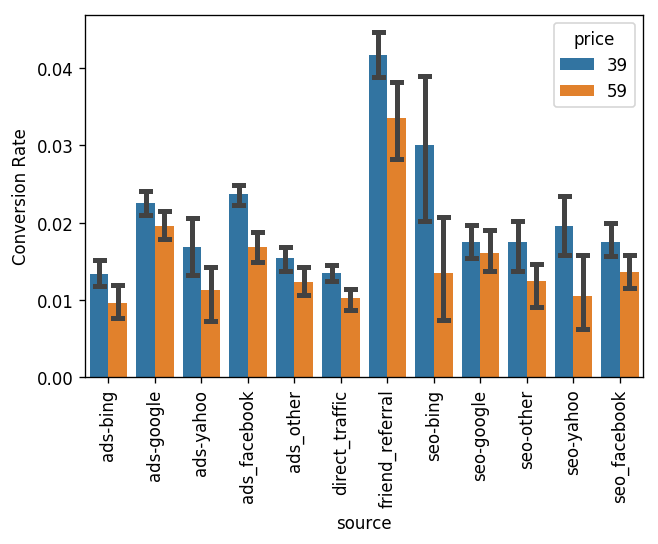

In [14]:
sns.barplot(data=df_results, x='device', y='converted', hue='price', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.ylabel('Conversion Rate')
plt.show()

sns.barplot(data=df_results, x='operative_system', y='converted', hue='price', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.xticks(rotation=90)
plt.ylabel('Conversion Rate')
plt.show()

sns.barplot(data=df_results, x='source', y='converted', hue='price', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.xticks(rotation=90)
plt.ylabel('Conversion Rate')
plt.show()

## Looking at geographic distribution of customers
We immediately see that there are few customers outside of the US in the user table. We can divide the US into regions by clustering be lattitue and longitude. These regions seem to have no difference in conversion rate. This suggests that geographic segmentation is not appropriate for setting the price.

(-167.20615053763441,
 39.716150537634405,
 17.62499834437086,
 63.255001655629144)

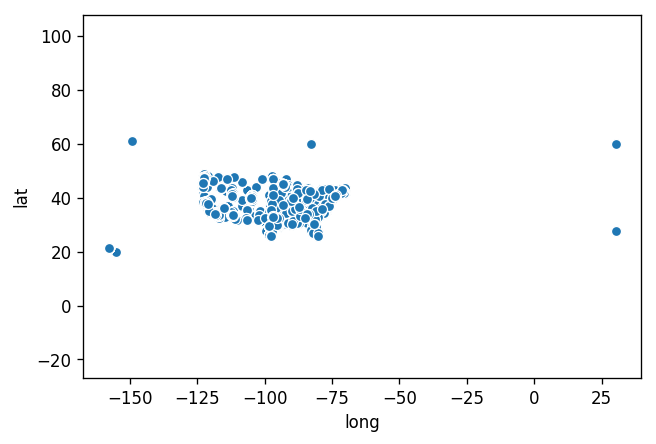

In [15]:
sns.scatterplot(data=df_results, x='long', y='lat')
plt.axis('equal')

/home/pavel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pavel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(-167.20615053763441,
 39.716150537634405,
 17.62499834437086,
 63.255001655629144)

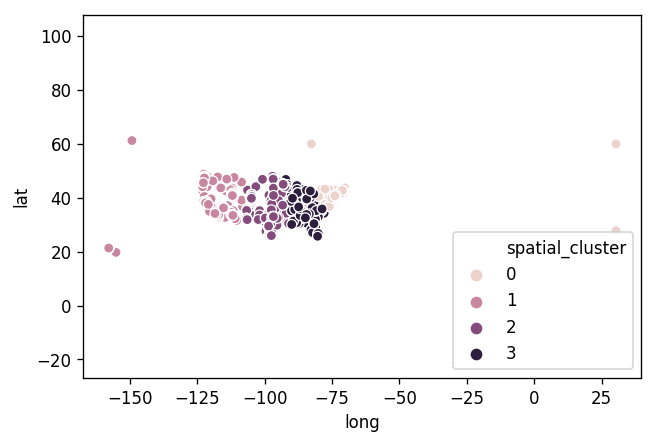

In [16]:
from sklearn.cluster import KMeans

map_data = df_results.dropna()

X = map_data[['lat','long']]
kmeans = KMeans(n_clusters=4).fit(X)

map_data.loc[:,'spatial_cluster'] = kmeans.labels_

sns.scatterplot(data=map_data, x='long', y='lat', hue='spatial_cluster')
plt.axis('equal')

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


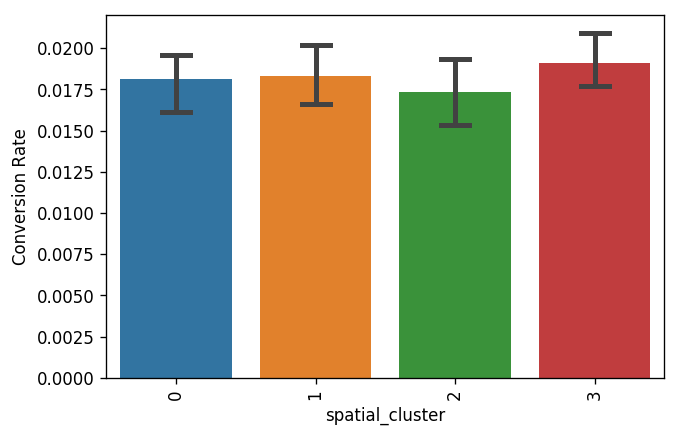

In [17]:
sns.barplot(data=map_data, x='spatial_cluster', y='converted', errwidth=3, capsize=0.2, n_boot=100, ci=95)
plt.xticks(rotation=90)
plt.ylabel('Conversion Rate')
plt.show()

# Choosing adequate sample size
The sample size required is determined by the false positive, false negative rate, and minimum effect size we are willing to tolerate. I used a conventional false positive rate of alpha = 0.05. Let's say that we are willing to have a false negative 5% of the time, or beta = 0.05. Statistical power = 1 - beta = 0.95.

For the case of this problem, we calculated signifigance using a student's t-test. I'm assuming that in the future we can try a control:experimental ratio of 1:1 so that the experiment can be concluded faster.

In [18]:
from statsmodels.stats.power import TTestIndPower

analysis = TTestIndPower()
minimum_sample_size = analysis.solve_power(0.2, power=0.95, nobs1=None, ratio=1, alpha=0.05)

print('The minimal sample size is: ' + str(round(minimum_sample_size + 0.)))

The minimal sample size is: 651


# Conclusions
## Answers
1. Increasing the price of the software from \$39 to \$59 should yield an **increase in revenue of 18%**. Given this, **I advise raising the price**.
2. Some observations regarding the data
    1. Conversion rate varies by OS with: **iOS/mac > windows/android > linux**
    2. Conversion rate varies by source, and **friend referrals double conversion rate**
    3. Conversion rate decreased under all os, device, and source conditions, although we do not have sufficient statistical power to conclude that at alpha = 0.05 in some cases
    4. The e
3. An experiment of around 1,000 samples should be sufficient if we don't care about segmenting our users. I would not advise experiments as large as this one in the future.